In [1]:
import torch
from optimize_ARPDF import ARPDFModel, ARPDFOptimizer
from collections import Counter
import MDAnalysis as mda
import utils
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\Users\swz\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
u0 = mda.Universe('data/CCl4/CCl4.gro')
device = torch.device('cuda')
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_exp, Counter(u0.atoms.types), cutoff=10.0, 
    lr=0.01, gamma=0.995, f_lb=-0.9, s=0.0, beta=0.0, epochs=500, device=device
)
ARPDF_optimizer.set_system(cur_dir='tmp/circ_sim_wc_6')

In [3]:
# print(json.dumps({k: str(type(v)) for k, v in ARPDF_optimizer.__dict__.items()}, indent=4))
# print(json.dumps({k: str(type(v)) for k, v in ARPDF_optimizer.model.__dict__.items()}, indent=4))

lr: 0.009950
Epoch 0, Loss: -0.567689, CosSim: 0.191252
lr: 0.009704
Epoch 5, Loss: -0.618540, CosSim: 0.192935
lr: 0.009464
Epoch 10, Loss: -0.628883, CosSim: 0.180996
lr: 0.009229
Epoch 15, Loss: -0.636165, CosSim: 0.193559
lr: 0.009001
Epoch 20, Loss: -0.645389, CosSim: 0.228067
lr: 0.008778
Epoch 25, Loss: -0.656090, CosSim: 0.261381
lr: 0.008561
Epoch 30, Loss: -0.665403, CosSim: 0.299012
lr: 0.008349
Epoch 35, Loss: -0.673731, CosSim: 0.329752
lr: 0.008142
Epoch 40, Loss: -0.683314, CosSim: 0.365233
lr: 0.007941
Epoch 45, Loss: -0.687749, CosSim: 0.407357
lr: 0.007744
Epoch 50, Loss: -0.687110, CosSim: 0.425662
lr: 0.007553
Epoch 55, Loss: -0.689051, CosSim: 0.424418
lr: 0.007366
Epoch 60, Loss: -0.692722, CosSim: 0.417887
lr: 0.007183
Epoch 65, Loss: -0.694090, CosSim: 0.413265
lr: 0.007005
Epoch 70, Loss: -0.695953, CosSim: 0.410755
lr: 0.006832
Epoch 75, Loss: -0.696165, CosSim: 0.409476
lr: 0.006663
Epoch 80, Loss: -0.698911, CosSim: 0.403471
lr: 0.006498
Epoch 85, Loss: -0.6

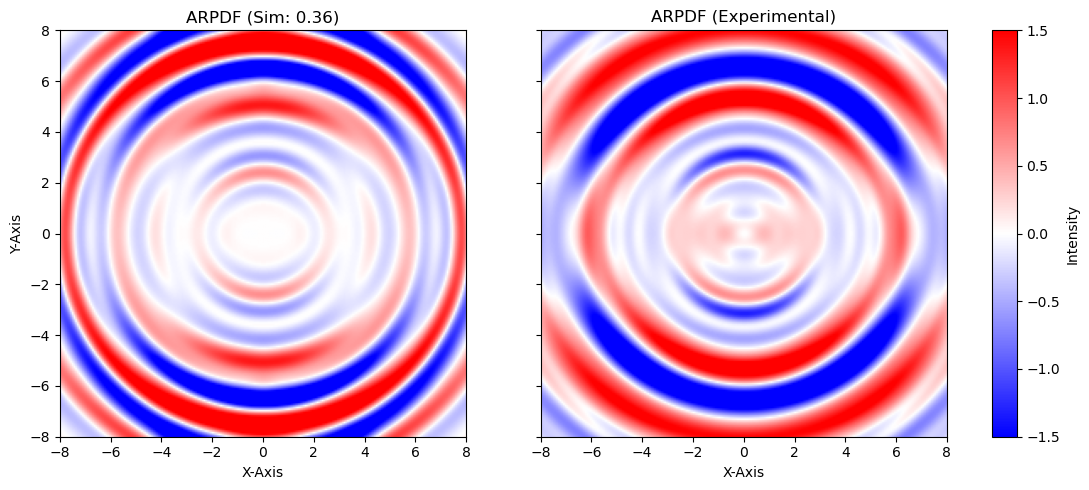

In [4]:
ARPDF_optimizer.optimize()

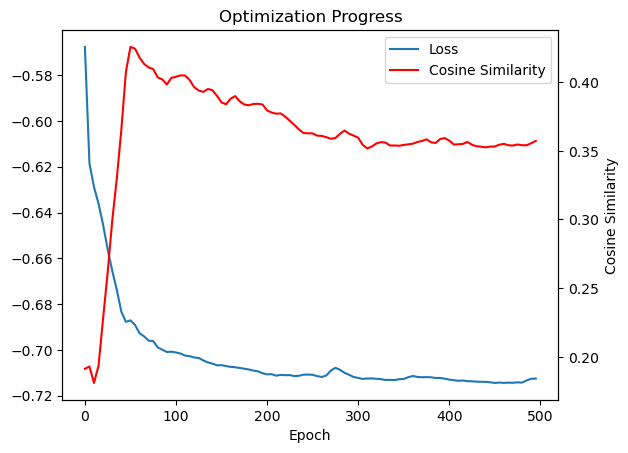

In [8]:
df = pd.read_csv("tmp/circ_sim_wc_6/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
cos_sim = df['cos_sim'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, cos_sim, label='Cosine Similarity', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Cosine Similarity'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [12]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data('tmp/circ_sim_wc_6')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load("tmp/circ_sim_wc_6/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
center_group = u2.atoms[modified_atoms]
_center = center_group[0].position[None, :]
around_group = u2.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer("tmp/circ_sim_wc_6/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)

In [10]:
a = np.ones((2, 3, 3))
b = np.arange(9).reshape(3, 3)
print(a @ b)

[[[ 9. 12. 15.]
  [ 9. 12. 15.]
  [ 9. 12. 15.]]

 [[ 9. 12. 15.]
  [ 9. 12. 15.]
  [ 9. 12. 15.]]]
